In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader


from datasets import load_dataset, DatasetDict, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration,  DataCollatorWithPadding

/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)


In [3]:
dataset = load_dataset('HuggingFaceH4/databricks_dolly_15k')
#dataset = load_dataset('HuggingFaceH4/asss')
df = pd.DataFrame(dataset['train'])
dataset


Found cached dataset parquet (/home/uj-user/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--databricks_dolly_15k-6252f3495e7d2b9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 777.15it/s]


DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 15015
    })
})

In [4]:
df = df[df != ''].dropna()
df.reset_index(drop=True, inplace=True)
df

,category,instruction,input,output
0,closed_qa,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...
1,closed_qa,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981."
2,information_extraction,If I have more pieces at the time of stalemate...,Stalemate is a situation in chess where the pl...,No. \nStalemate is a drawn position. It doesn'...
3,closed_qa,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...
4,information_extraction,Who was John Moses Browning?,"John Moses Browning (January 23, 1855 – Novemb...",John Moses Browning is one of the most well-kn...
...,...,...,...,...
4593,information_extraction,When did Phil Knight announce he would step do...,"Throughout the 1980s, Nike expanded its produc...",Phil Knight announced he would step down in 20...
4594,closed_qa,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...
4595,closed_qa,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...
4596,closed_qa,What is one-child policy?,The term one-child policy refers to a populati...,"The ""one-child policy"" was a Chinese populatio..."


In [5]:
df['category'].value_counts()

closed_qa                 1823
information_extraction    1512
summarization             1263
Name: category, dtype: int64

In [6]:
df = df[df['category'].str.contains('closed_qa')]
df.reset_index(drop=True, inplace=True)
df

,category,instruction,input,output
0,closed_qa,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...
1,closed_qa,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981."
2,closed_qa,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...
3,closed_qa,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...,Kyle Van Zyl was playing against Boland U21 wh...
4,closed_qa,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...
...,...,...,...,...
1818,closed_qa,How many types of cat does the world cat feder...,"As of 2023, The International Cat Association ...",69
1819,closed_qa,What is the history of coffee?,The history of coffee dates back to centuries ...,Much of the early history of coffee was tied t...
1820,closed_qa,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...
1821,closed_qa,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...


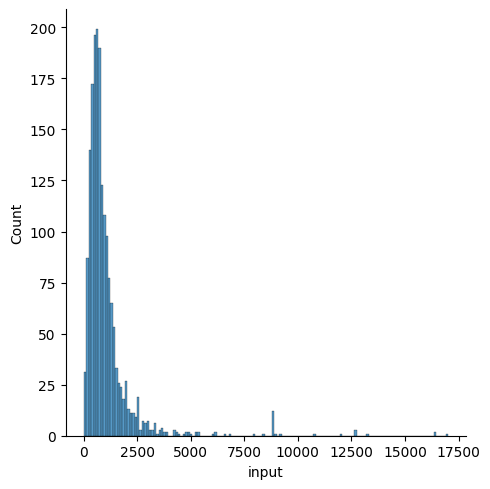

In [7]:
import seaborn as sns
length = df['input'].apply(len)
sns.displot(length)

In [8]:
from sklearn.model_selection import train_test_split


# 카테고리 전처리
prep_df = df[df['category']!='']#[:5000]
prep_df['category'] = prep_df['category'].apply(lambda x: 'Commonsense/logic' if x=="Common Sense / Logic" else x)
prep_df = prep_df.sort_values('category')

train_dataset, valid_dataset = train_test_split(prep_df, random_state=2022, test_size=0.2)


train = Dataset.from_pandas(train_dataset, preserve_index=False)
valid = Dataset.from_pandas(valid_dataset, preserve_index=False)
dataset = DatasetDict({'train':train, 'valid':valid})
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 1458
    })
    valid: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 365
    })
})

In [9]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

def clean(example): 
    pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣\[\]]+')
    url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

    x_key = ['instruction', 'input', 'output']
    
    for key in x_key:
        x = example[key]
        # x = pattern.sub(' ', x)
        x = emoji.replace_emoji(x, replace='') #emoji 삭제
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        example[key] = x

    return example

dataset = dataset.map(clean)
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 1458
    })
    valid: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 365
    })
})

In [10]:
prep_df.to_json('./prep_data.json', index=True, orient='records')

In [11]:
from nltk.tokenize import sent_tokenize

def preprocess_func(example):
    return tokenizer(example["output"], truncation=True, padding=False)

tokenized_datasets = dataset.map(preprocess_func, batched=True)
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "decoder_input_ids")
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column('attention_mask', 'decoder_attention_mask')
tokenized_datasets['valid'] = tokenized_datasets['valid'].rename_column("input_ids", "decoder_input_ids")
tokenized_datasets['valid'] = tokenized_datasets['valid'].rename_column('attention_mask', 'decoder_attention_mask')


def preprocess_function(example):
    sentence_ids_l, sentence_atten_mask_l = [], []
    instruction = tokenizer(example["instruction"], truncation=True, padding=False, max_length=128)
    sentence_ids_l.append(instruction['input_ids'])
    sentence_atten_mask_l.append(instruction['attention_mask'])
    
    for sent in sent_tokenize(example['input']):
        tokenized_sent = tokenizer(sent, truncation=True, padding=False, max_length=128)
        if len(tokenized_sent['input_ids']) > 4 and len(sentence_ids_l) < 8: # text length, batch size
            sentence_ids_l.append(tokenized_sent['input_ids'])
            sentence_atten_mask_l.append(tokenized_sent['attention_mask'])
    
    example['input_ids'] = sentence_ids_l
    example['attention_mask'] = sentence_atten_mask_l
    return example

tokenized_datasets = tokenized_datasets.map(preprocess_function)
# tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "encoder_input_ids")
# tokenized_datasets['train'] = tokenized_datasets['train'].rename_column('attention_mask', 'encoder_attention_mask')

tokenized_datasets.set_format("torch")
tokenized_datasets = tokenized_datasets.remove_columns(['category', 'instruction', 'input', 'output',])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['decoder_input_ids', 'decoder_attention_mask', 'input_ids', 'attention_mask'],
        num_rows: 1458
    })
    valid: Dataset({
        features: ['decoder_input_ids', 'decoder_attention_mask', 'input_ids', 'attention_mask'],
        num_rows: 365
    })
})

In [12]:
from torchmetrics.text.rouge import ROUGEScore

def validation(model, valid_dataloader):
    avg_rouge_score = []
    for enc_inputs, dec_input in tqdm(valid_dataloader):
        
        hidden_states = []
        for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
            input_ids = input_ids.unsqueeze(dim=0).to(device)
            outputs = model.encoder(input_ids=input_ids).last_hidden_state
            hidden_states.append(outputs)
                
        for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
            input_ids = input_ids.unsqueeze(dim=0).to(device)
            break

        dec_input_ids = dec_input['input_ids'].unsqueeze(dim=0)
        # encoder_outputs=torch.cat(hidden_states, dim=0).to(device)
        # enc_baseoutput = BaseModelOutput(last_hidden_state=encoder_outputs)

        outputs = model.generate(input_ids =input_ids,
                                encoder_outputs=hidden_states, 
                                #  labels=input_ids
                                )
        
        # question = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        target = tokenizer.decode(dec_input_ids[0], skip_special_tokens=True)
        # print('Q:', question)
        # print('A:', pred)
        # print('GT:', target, '\n')
        # torch.cuda.empty_cache()
        
        rouge = ROUGEScore()
        rouge_score = rouge(pred, target)
        avg_rouge_score.append(rouge_score)
    return pd.DataFrame(avg_rouge_score).mean().to_dict()

In [ ]:
model_name = "google/flan-t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_name, output_hidden_states=True).to(device)

In [16]:
from torch.utils.data import DataLoader
from transformers.modeling_outputs import BaseModelOutput
from tqdm import tqdm
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


def collate_fn(batch):
    batch = batch[0]
    decoder_input_ids, decoder_attention_mask, input_ids, attention_mask = batch['decoder_input_ids'], batch['decoder_attention_mask'], batch['input_ids'], batch['attention_mask'],

    pad_encoder_input = tokenizer.pad({'input_ids': batch['input_ids']}, padding=True, max_length=128, return_tensors='pt')
    pad_decoder_input = tokenizer.pad({'input_ids': batch['decoder_input_ids']}, padding=True, max_length=128, return_tensors='pt')
    
    return pad_encoder_input, pad_decoder_input


train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=False, batch_size=1, collate_fn=collate_fn)
valid_dataloader = DataLoader(tokenized_datasets["valid"], shuffle=False, batch_size=1, collate_fn=collate_fn)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_epoch = 5

import wandb
wandb.init(project='t5_sum',
           tags=['new', model_name],
           )
wandb.watch(model)
for e in range(train_epoch):
    train_loss = []
    total, correct = 0, 0
    model.train()

    for enc_inputs, dec_input in tqdm(train_dataloader):
        
        hidden_states = []
        for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
            input_ids = input_ids.unsqueeze(dim=0).to(device)
            outputs = model.encoder(input_ids=input_ids).last_hidden_state#, labels=dec_input)
            hidden_states.append(outputs)
            torch.cuda.empty_cache()
        
        for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
            input_ids = input_ids.unsqueeze(dim=0)
            break
        
        encoder_outputs=torch.cat(hidden_states, dim=0)
        input_ids = input_ids.repeat(encoder_outputs.shape[0], 1).to(device)
        
        dec_input_ids = dec_input['input_ids'].unsqueeze(dim=0)
        dec_input_ids = dec_input_ids.repeat(encoder_outputs.shape[0], 1).to(device)
        
        enc_baseoutput = BaseModelOutput(last_hidden_state=encoder_outputs)
        
        text_output = model(input_ids=input_ids,
                            encoder_outputs=enc_baseoutput, 
                            labels=dec_input_ids[:,:-1].contiguous()
                            )

        loss = text_output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print(loss)
        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    print(f'Epoch:{e}, Train_loss:{avg_loss}')
    
    valid_log = validation(model, valid_dataloader)
    wandb.log({'train_loss':avg_loss})
    wandb.log(valid_log)
    
    # print(loss)
    # print(logits)
    # print(tokenizer.decode(enc_inputs['input_ids'][0], skip_special_tokens=True))
    # print(tokenizer.decode(torch.argmax(text_output.logits, dim=2)[0], skip_special_tokens=True))
wandb.finish()

  0%|          | 0/1458 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1458/1458 [08:03<00:00,  3.01it/s]


Epoch:0, Train_loss:2.657399411043676


  0%|          | 0/365 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/1458 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1458/1458 [08:06<00:00,  3.00it/s]


Epoch:1, Train_loss:2.574915746612722


  0%|          | 0/365 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/1458 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1458/1458 [07:58<00:00,  3.05it/s]


Epoch:2, Train_loss:2.4978730643042892


  0%|          | 0/365 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/1458 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1458/1458 [07:55<00:00,  3.07it/s]


Epoch:3, Train_loss:2.415734464862219


  0%|          | 0/365 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/1458 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1458/1458 [07:55<00:00,  3.06it/s]


Epoch:4, Train_loss:2.349865867691153


  0%|          | 0/365 [00:00<?, ?it/s]/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 365/365 [01:50<00:00,  3.31it/s]


rouge1_fmeasure,▃█▇▁▄
rouge1_precision,██▇▁▂
rouge1_recall,▅█▅▁▅
rouge2_fmeasure,▁█▅▁▇
rouge2_precision,▂█▄▁▅
rouge2_recall,▁█▅▂▆
rougeL_fmeasure,▁█▆▁▅
rougeL_precision,▃█▇▁▃
rougeL_recall,▃█▄▁▆
rougeLsum_fmeasure,▁██▂█
rougeLsum_precision,▆▆█▁▄


In [18]:
avg_rouge_score = []
for enc_inputs, dec_input in valid_dataloader:
    
    hidden_states = []
    for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
        input_ids = input_ids.unsqueeze(dim=0).to(device)
        outputs = model.encoder(input_ids=input_ids).last_hidden_state
        hidden_states.append(outputs)
            
    for input_ids, attention_mask in zip(enc_inputs['input_ids'], enc_inputs['attention_mask']):
        input_ids = input_ids.unsqueeze(dim=0).to(device)
        break

    dec_input_ids = dec_input['input_ids'].unsqueeze(dim=0)
    # encoder_outputs=torch.cat(hidden_states, dim=0).to(device)
    # enc_baseoutput = BaseModelOutput(last_hidden_state=encoder_outputs)

    outputs = model.generate(input_ids =input_ids,
                            encoder_outputs=hidden_states, 
                            #  labels=input_ids
                            )
    
    question = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    target = tokenizer.decode(dec_input_ids[0], skip_special_tokens=True)
    print('Q:', question)
    print('A:', pred)
    print('GT:', target, '\n')
    # torch.cuda.empty_cache()
    
    rouge = ROUGEScore()
    rouge_score = rouge(pred, target)
    avg_rouge_score.append(rouge_score)
pd.DataFrame(avg_rouge_score).mean()

/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2390: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/uj-user/Yo/dolly-15k-analysis/dolly-venv/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: What was Jiang's previous position before becoming the president of China?
A: China's president was Liu Wenqi. He was the first Chinese president to
GT: He was the mayor of Shanghai and then became Communist Party secretary 

Q: When did Arsenal first reach the first division? How many league titles did they win between 1989 and 2005 and how many FA cups? How many trophies in total for that period?
A: 1989 to 2005 and a total of ten trophies. Arsenal won the FA Cup
GT: Arsenal reached the first division in 1904. Between 1989 and 2005, Arsenal won 5 league titles and 5 FA cups. That’s a total of 10 trophies. 

Q: Based on the following paragraph on the current use of obsidian, what's the difference between obsidian scalpels and steel scalpels?
A: The difference between obsidian and steel scalpels is that both are used for a variety
GT: Obsidian scalpels have a cutting edge that is many times sharper than a steel scalpel. In addition, obsidian scalpels have a smooth blade surface wher

rouge1_fmeasure        0.261857
rouge1_precision       0.377535
rouge1_recall          0.257054
rouge2_fmeasure        0.115347
rouge2_precision       0.156443
rouge2_recall          0.114406
rougeL_fmeasure        0.229518
rougeL_precision       0.326609
rougeL_recall          0.229346
rougeLsum_fmeasure     0.240040
rougeLsum_precision    0.345583
rougeLsum_recall       0.238474
dtype: float64

In [ ]:
def train(model, train_loader, valid_loader, optimizer, scheduler):
    best_model = None
    best_acc = 0

    for epoch in range(1, CFG['EPOCHS']+1):
        train_loss = []
        total, correct = 0, 0
        model.train()
        
        for i, (x, y) in enumerate(tqdm(train_loader)):
            with accelerator.accumulate(model):
                x = x.to(device) 
                y = y.flatten().to(device)

                optimizer.zero_grad()
                output = model(x)
                loss = creterion(output, y)
                accelerator.backward(loss) #loss.backward()
                
                _, predicted = torch.max(output, 1)
                total += y.size(0)
                correct += predicted.eq(y).cpu().sum()
        
                if (i+1) % accumulation_step == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                train_loss.append(loss.item())

        train_acc = correct / total
        avg_loss = np.mean(train_loss)
        valid_loss, valid_acc = validation(model, valid_loader, creterion)

        if scheduler is not None:
            scheduler.step(valid_acc)

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            os.makedirs(f"model", exist_ok=True)
            torch.save(unwrapped_model.state_dict(), f"model/{CFG['MODEL_NAME'].replace('/', '_')}_b{CFG['TOTAL_BATCH_SIZE']}_epoch{CFG['EPOCHS']}_lr{CFG['LR']}_e{epoch}_vl{valid_loss:.4f}va{valid_acc:.4f}.pth")

        accelerator.print(f'epoch:[{epoch}] train loss:[{avg_loss:.5f}] valid_loss:[{valid_loss:.5f}] trainacc:[{train_acc:.5f}] valid_acc:[{valid_acc:.5f}]')
        accelerator.log({'train_loss': avg_loss, 'valid_loss': valid_loss, 'train_acc:':train_acc, 'valid_acc': valid_acc}, step=epoch)
    accelerator.print(f'best_acc:{best_acc:.5f}')
    return best_model